# Bird-Building Collisions - An Evaluation using GridDB 

## The Alarming Upsurge of Bird-Building Collisions

Skyscrapers and tall towers look splendid and can uplift the look of any city. Big buildings and bright lights are great to look at, and perfectly safe for human beings. But are they safe for birds? Apparently not. According to the Audubon Mid-Atlantic, atleast 365 million birds collide with buildings every year in the United States. The numbers can go upto 1 billion in some cases. Scientists warn that while bird-building collisions can result in an increased mortality of birds, they also lead to the decline and subsequent extinction of many bird species. In this article, we use GridDB and Python to derive insights into this often-overlooked threat. 

<div><img src="image.jpg" width="500"/></div> 

<center> Photo by <a href="https://images.unsplash.com/photo-1532598187460-98fe8826d1e2?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=764&q=80">Taneli Lahtinen</a> on <a href="https://images.unsplash.com/photo-1532598187460-98fe8826d1e2?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=764&q=80t">Unsplash</a> </center>
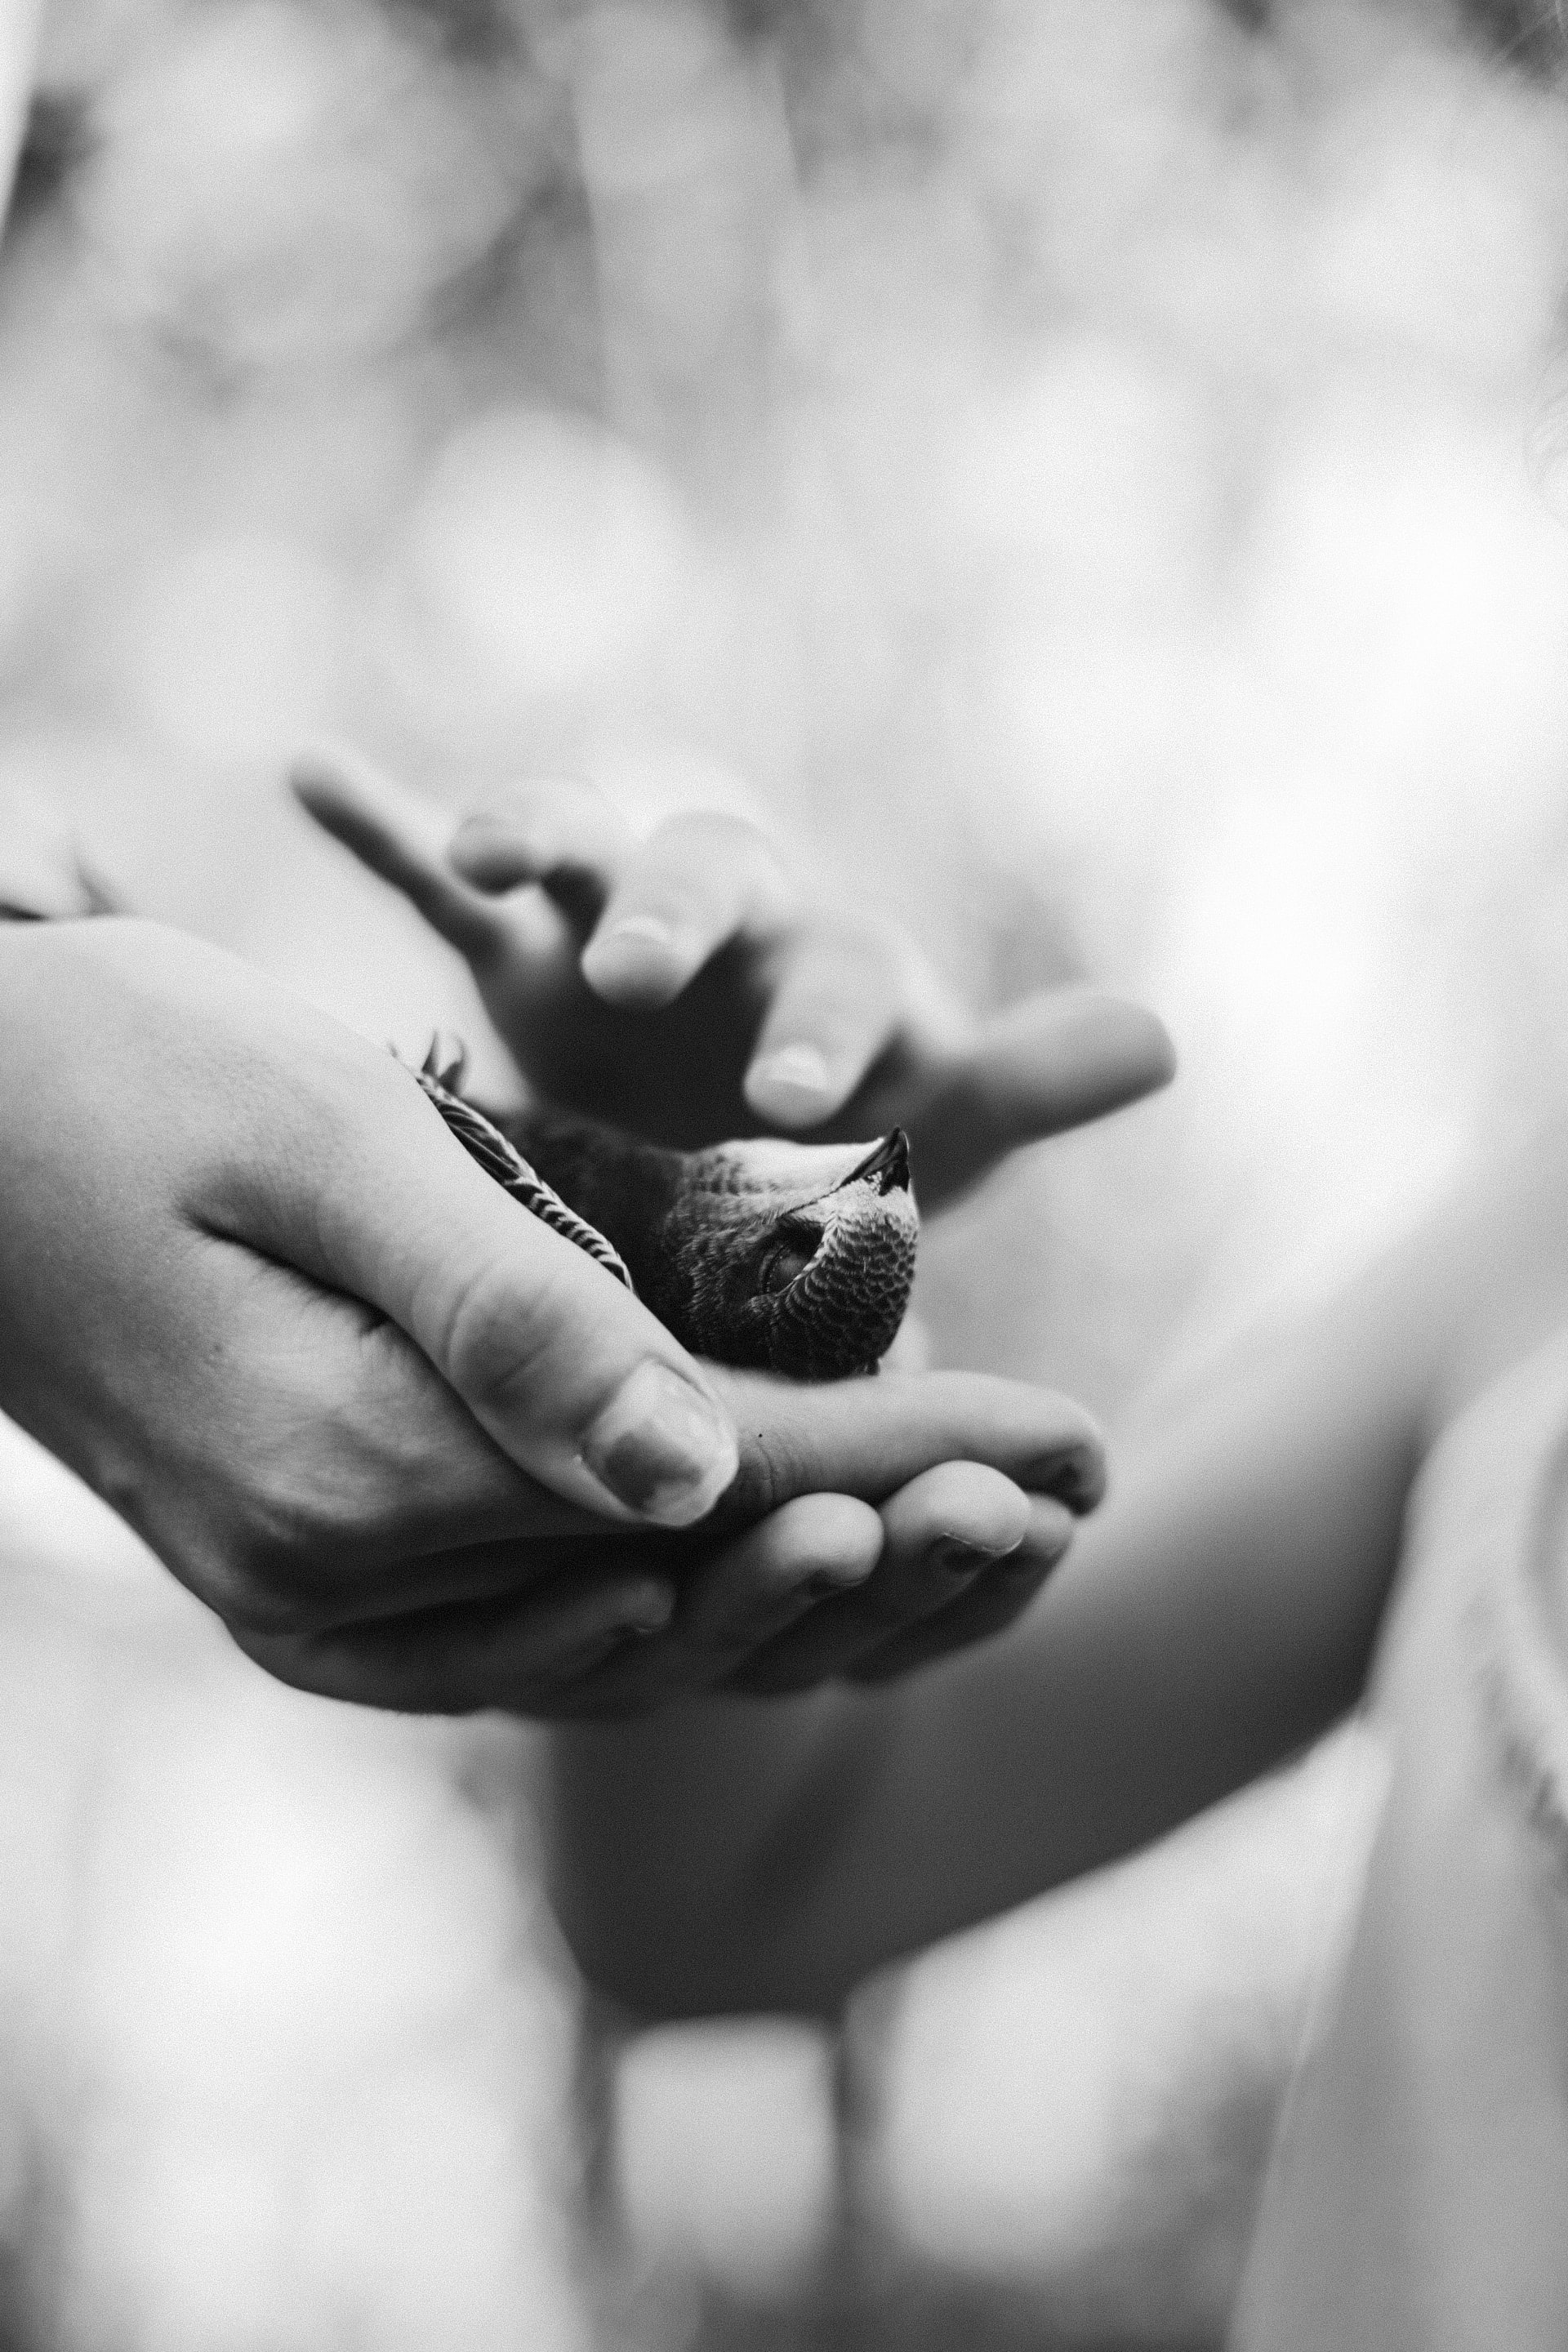

In [154]:
import os
import pandas as pd
import numpy as np
import requests  # to make http calls
import http
http.client.HTTPConnection.debuglevel = 1
from datetime import date
from datetime import datetime
import json # to parse different data objects like string, etc. to JSON
import tabulate
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import random

## The Dataset

The dataset used for this analysis can be downloaded from <a href = "https://data.world/animals/bird-building-collisions"> data.world </a> or from the official website of <a href = "https://datadryad.org/stash/dataset/doi:10.5061/dryad.8rr0498"> DRYAD </a>. The Dataset contains collisions recorded in Chicago and Cleveland along with the associated light levels. Please not that this data is limited to Chicago and Cleveland and hence are not representative of other states in the United States.

<b> Citation: </b> Winger, Benjamin M. et al. (2019), Nocturnal flight-calling behaviour predicts vulnerability to artificial light in migratory birds, Proceedings of the Royal Society B: Biological Sciences, Article-journal, https://doi.org/10.1098/rspb.2019.0364

In [155]:
os.chdir("C:\\Users\\Desktop\\GridDB)
Chicago_Collisions = pd.read_csv("Chicago_collision_data.csv", sep =",")
Cleveland_Collisions = pd.read_csv("Cleveland_collision_data.csv", sep =",")
Light_levels = pd.read_csv("Light_levels_dryad.csv", sep =",")

For Collection containers, the rowkey can be of any type. However, for Timeseries containers, the <b> rowkey </b> should be of the <b> timestamp </b> format. Hence, we process the 'Date' field in the form of a timestamp.

In [156]:
Chicago_Collisions['Date'] = Chicago_Collisions['Date'] + " 00:00:00"
Cleveland_Collisions['Date'] = Cleveland_Collisions['Date'] + " 00:00:00"
Light_levels['Date'] = Light_levels['Date'] + " 00:00:00"

Chicago_Collisions['Date'] = pd.to_datetime(Chicago_Collisions['Date'])
Cleveland_Collisions['Date'] = pd.to_datetime(Cleveland_Collisions['Date'])
Light_levels['Date'] = pd.to_datetime(Light_levels['Date'])
Light_levels.Light_Score = Light_levels.Light_Score.astype(str)

## Importance of Uniqueness of Timestamps

<b> Timeseries Containers in GridDB require you to have unique timestamp values. If not, they will overwrite each other. </b>
Note that as we converted dates to timestamps, rows which have the same date will also have the same timestamp value. Hence, printing out the number of rows inserted may not be a true validation. To prevent an over-write, let's add a random number of seconds to each timestamp value to ensure that the values are unique. 

In [ ]:
myCounter = 0
for i, row in Chicago_Collisions.iterrows():
    myCounter = myCounter+1
    Chicago_Collisions.loc[i, "Date"] = row['Date'] + pd.DateOffset(seconds=myCounter)

myCounter = 0
for i, row in Cleveland_Collisions.iterrows():
    myCounter = myCounter+1
    Cleveland_Collisions.loc[i, "Date"] = row['Date'] + pd.DateOffset(seconds=myCounter)

myCounter = 0
for i, row in Light_levels.iterrows():
    myCounter = myCounter+1
    Light_levels.loc[i, "Date"] = row['Date'] + pd.DateOffset(seconds=myCounter)

### Changing the sequence of columns
The columns need to be re-ordered such that the 'Date' is the first column in the data. This is because time-series containers in GridDB expect a timestamp column to be the first key column.

In [158]:
chicago_cols = list(Chicago_Collisions.columns.values)
chicago_cols # ['Genus', 'Species', 'Date', 'Locality']
# Re-arrange to ['Date', 'Genus', 'Species', 'Locality']
Chicago_Collisions = Chicago_Collisions[['Date', 'Genus', 'Species', 'Locality']]

In [159]:
cleveland_cols = list(Cleveland_Collisions.columns.values)
cleveland_cols # ['Genus', 'Species', 'Date']
# Re-arrange to ['Date', 'Genus', 'Species']
Cleveland_Collisions = Cleveland_Collisions[['Date', 'Genus', 'Species']]

### Formatting Date as Timestamp
GridDB requires the key column for its timeseries to be of the format %Y-%m-%dT%H:%M:%SZ. As an example, the expected format is 2022-10-16T12:00:00Z.

In [160]:
Chicago_Collisions['Date'] = Chicago_Collisions['Date'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.000Z"))

In [161]:
cleveland_cols = list(Cleveland_Collisions.columns.values)
cleveland_cols #['Genus', 'Species', 'Date']
# Re-arrange to ['Date','Genus','Species']
Cleveland_Collisions = Cleveland_Collisions[['Date', 'Genus', 'Species']]

In [162]:
Cleveland_Collisions['Date'] = Cleveland_Collisions['Date'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.000Z"))

In [163]:
Light_levels['Date'] = Light_levels['Date'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.000Z"))

## Constructing the Container - Setting up the Data Model

As you might already know, GridDB is highly scaleable NoSQL database that extends the typical Key-value store model to a key-container model. In addition, it supports two types of containers - a Collection and a Time Series Container. Refer to https://griddb.net/en/blog/data-modeling-with-griddb/ to learn more on how GridDB compares to other NoSQL databases like Riak, Cassandra and MongoDB and why GridDB is the best of the lot. This resource also clearly explains how each type of container needs to be created. The rowkey determines the type of container. In this case, our data model looks like the one below - 

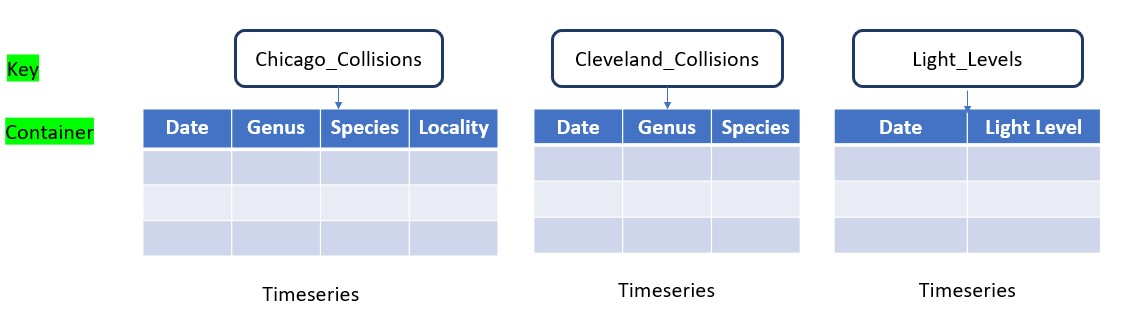

## Creating the Request (& Containers)

As per our requirements, we are required to create 3 containers. While constructing a time series container, note that the container type should be 'TIME_SERIES' and the rowkey must be set to 'True'.

In [164]:
#Construct an object to hold the request headers (ensure that you replace the XXX placeholder with the correct value that matches the credentials for your GridDB instance)
header_obj = {"Authorization":"XXX","Content-Type":"application/json; charset=UTF-8","User-Agent":"PostmanRuntime/7.29.0"}

#Construct the base URL based on your GridDB cluster you'd like to connect to (ensure that you replace the placeholders in the URL below with the correct values that correspond to your GridDB instance)
#'https://[host]:[port]/griddb/v2/[clustername]/dbs/[database_name]'
base_url = 'https://[host]:[port]/griddb/v2/[clustername]/dbs/[database_name]'

In [165]:
#Creating the container 'Chicago_Collisions'
#Construct an object to hold the request body (i.e., the first container that needs to be created)
# Genus,Species,Date,Locality
data_obj_1 = {
    "container_name": "Chicago_Collisions",
    "container_type": "TIME_SERIES",
    "rowkey": True,
    "columns": [
    {
    "name": "Date",
    "type": "TIMESTAMP"
    },
    {
    "name": "Genus",
    "type": "STRING"
    },
    {
    "name": "Species",
    "type": "STRING"
    },
    {
    "name": "Locality",
    "type": "STRING"
    }
    ]
}

In [ ]:
#Set up the GridDB WebAPI URL
url = base_url+'containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj_1, headers = header_obj)

Here's a <b> TIP </b>: If you are new to GridDB and need help understanding the data types, check out this resource - <a href= "https://docs.griddb.net/tqlreference/type/#floating-point"> 'Data Types in GridDB' </a> It is important to note that the data types are case sensitive e.g. Timestamp should be specified in upper case and not in title case or lower case.

In [167]:
#Creating the container 'Cleveland_Collisions'
#Construct an object to hold the request body (i.e., the second container that needs to be created)
data_obj_2 = {
    "container_name": "Cleveland_Collisions",
    "container_type": "TIME_SERIES",
    "rowkey": True,
    "columns": [
    {
    "name": "Date",
    "type": "TIMESTAMP"
    },
    {
    "name": "Genus",
    "type": "STRING"
    },
    {
    "name": "Species",
    "type": "STRING"
    },    
    ]
}

In [ ]:
#Set up the GridDB WebAPI URL
url = base_url + 'containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj_2, headers = header_obj)

In [169]:
#Creating the container 'Light_levels'
#Construct an object to hold the request body (i.e., the third container that needs to be created)
data_obj_3 = {
    "container_name": "Light_levels",
    "container_type": "TIME_SERIES",
    "rowkey": True,
    "columns": [
    {
    "name": "Date",
    "type": "TIMESTAMP"
    },
    {
    "name": "Light_Score",
    "type": "STRING"
    },    
    ]
}

In [ ]:
#Set up the GridDB WebAPI URL
url = base_url + 'containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj_3, headers = header_obj)

## Data Loading - Populating the containers with data (Row Registration)

Now that all containers have been loaded, we load the data from the three dataframes into each of the containers. The process of loading data into a container is also known as <b> 'Row Registration' </b>. To read more about it, refer to the GridDB resource <a href = "http://www.toshiba-sol.co.jp/en/pro/griddb/docs-en/v4_3/GridDB_Web_API_Reference.html#%E3%83%AD%E3%82%A6%E7%99%BB%E9%8C%B2"> here</a>. 

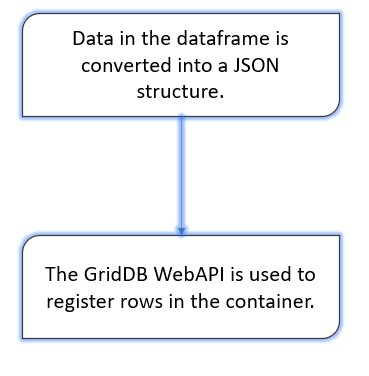
<center> Steps involved in Row Registration </center>

The 'to_json' function of the Pandas library is useful in constructing the JSON structure required for row registration.

### Populating data in the container 'Chicago_Collisions'

In [171]:
#Convert the data in the dataframe to the JSON format
Chicago_Collisions_json = Chicago_Collisions.to_json(orient='values')
request_body_chicago_collisions = Chicago_Collisions_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + 'containers/Chicago_Collisions/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_chicago_collisions, headers=header_obj)

In [173]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container Chicago_Collisions.')

69784 rows have been registered in the container Chicago_Collisions.


In [ ]:
###############################################
#Construct the SQL to be used
sql_query1 = ("SELECT count(*) as cnt FROM Chicago_Collisions")
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query1+'"}]'

#Invoke the GridDB WebAPI
query_req1 = requests.post(url, data=request_body, headers=header_obj)

#print the response and compare the output to the number of rows loaded
query_req1.text

### Populating data in the container 'Cleveland_Collisions'

In [197]:
#Convert the data in the dataframe to the JSON format
Cleveland_Collisions_json = Cleveland_Collisions.to_json(orient='values')
request_body_cleveland_collisions = Cleveland_Collisions_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + 'containers/Cleveland_Collisions/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_cleveland_collisions, headers=header_obj)

In [199]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container Cleveland_Collisions.')

2273 rows have been registered in the container Cleveland_Collisions.


In [ ]:
###############################################
#Construct the SQL to be used
sql_query1 = ("SELECT count(*) as cnt FROM Cleveland_Collisions")
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query1+'"}]'

#Invoke the GridDB WebAPI
query_req1 = requests.post(url, data=request_body, headers=header_obj)

#print the response and compare the output to the number of rows loaded
query_req1.text

### Populating data in the container 'Light_levels'

In [201]:
#Convert the data in the dataframe to the JSON format
Light_levels_json = Light_levels.to_json(orient='values')
request_body_Light_levels = Light_levels_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + 'containers/Light_levels/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_Light_levels, headers=header_obj)

In [203]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container Light_levels.')

3067 rows have been registered in the container Light_levels.


In [ ]:
###############################################
#Construct the SQL to be used
sql_query1 = ("SELECT count(*) as cnt FROM Light_levels")
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query1+'"}]'

#Invoke the GridDB WebAPI
query_req1 = requests.post(url, data=request_body, headers=header_obj)

#print the response and compare the output to the number of rows loaded
query_req1.text

## Querying the database

We are now going to find insightful answers to questions about Bird-Building collisions using GridDB's powerful query database. The three containers that were created are going to be queried for actionable insights. 

### Harnessing the timeseries functions of GridDB

GridDB offers easy to use time-series functions that can be leveraged for quick insights. Read more <a href =" https://docs.griddb.net/architecture/database-function/#operation-function-of-tql"> here.</a> Here, we use some time-series functions along with the standard sql functions available in GridDB.

### What is the range of data available for Collisions in Chicago?  

In [205]:
#Construct the SQL to be used
sql_query1 = ("SELECT max(Date) as cnt FROM Chicago_Collisions")

In [206]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query1+'"}]'

In [ ]:
#Invoke the GridDB WebAPI
query_req1 = requests.post(url, data=request_body, headers=header_obj)

In [208]:
query_req1.text

'[{"columns":[{"name":"cnt","type":"TIMESTAMP"}],"results":[["2016-11-30T17:05:37.000Z"]]}]'

There's data as recent as <b> November 2016 </b>.

In [209]:
#Construct the SQL to be used
sql_query2 = ("SELECT min(Date) as cnt FROM Chicago_Collisions")

In [210]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query2+'"}]'

In [ ]:
#Invoke the GridDB WebAPI
query_req2 = requests.post(url, data=request_body, headers=header_obj)

In [212]:
query_req2.text

'[{"columns":[{"name":"cnt","type":"TIMESTAMP"}],"results":[["1978-09-15T03:02:59.000Z"]]}]'

The 'Chicago Collisions' dataset has data from <b> 1978 to 2016 </b>.

### When did a collision take place in Chicago on or after the New Year 2014 (1st of Jan 2014)?

The start of every Year is indeed a happy occasion for all of us; but not for all living beings. Let's see if there was a bird that was killed on or after New Year's day.  

For this, we use the TIME_NEXT function of TQL. When this statement is used, GridDB selects a row whose timestamp is identical with or just after the specified timestamp. Read more about it <a href = "https://docs.griddb.net/tqlreference/tql-syntax-and-calculation-functions/#aggregation-operations-time-series"> here. </a> 

In this case, it fetches the specific bird-building collision that happened after 2014-01-01.

In [213]:
#Construct the TQL to be used
tql_query1 = "SELECT TIME_NEXT(*, TIMESTAMP('2014-01-01T00:00:00Z')) "

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + 'tql'

#Construct the request body which has the SQL that is to be used to retrieve the data
request_body = '[{"name":"Chicago_Collisions", "stmt":"'+tql_query1+'","columns":[]}]' 

#Invoke the GridDB WebAPI
query_req3 = requests.post(url, data=request_body, headers=header_obj)

In [215]:
query_req3.text

'[{"columns":[{"name":"Date","type":"TIMESTAMP"},{"name":"Genus","type":"STRING"},{"name":"Species","type":"STRING"},{"name":"Locality","type":"STRING"}],"results":[["2014-03-14T19:19:27.000Z","Melospiza","melodia","MP"]],"offset":0,"limit":10000,"total":-1}]'

<b>Insight: </b>
As per the <b> TIME_NEXT </b> function, the very next time a collision has been recorded after 2014-01-01 is <b> 2014-03-14</b>. A bird of the Melospiza genus and Melodia species was killed in McCormick Place, Chicago. In other words, a <b> song sparrow </b> was killed in a bird-building collision after  2014-01-01.

<div>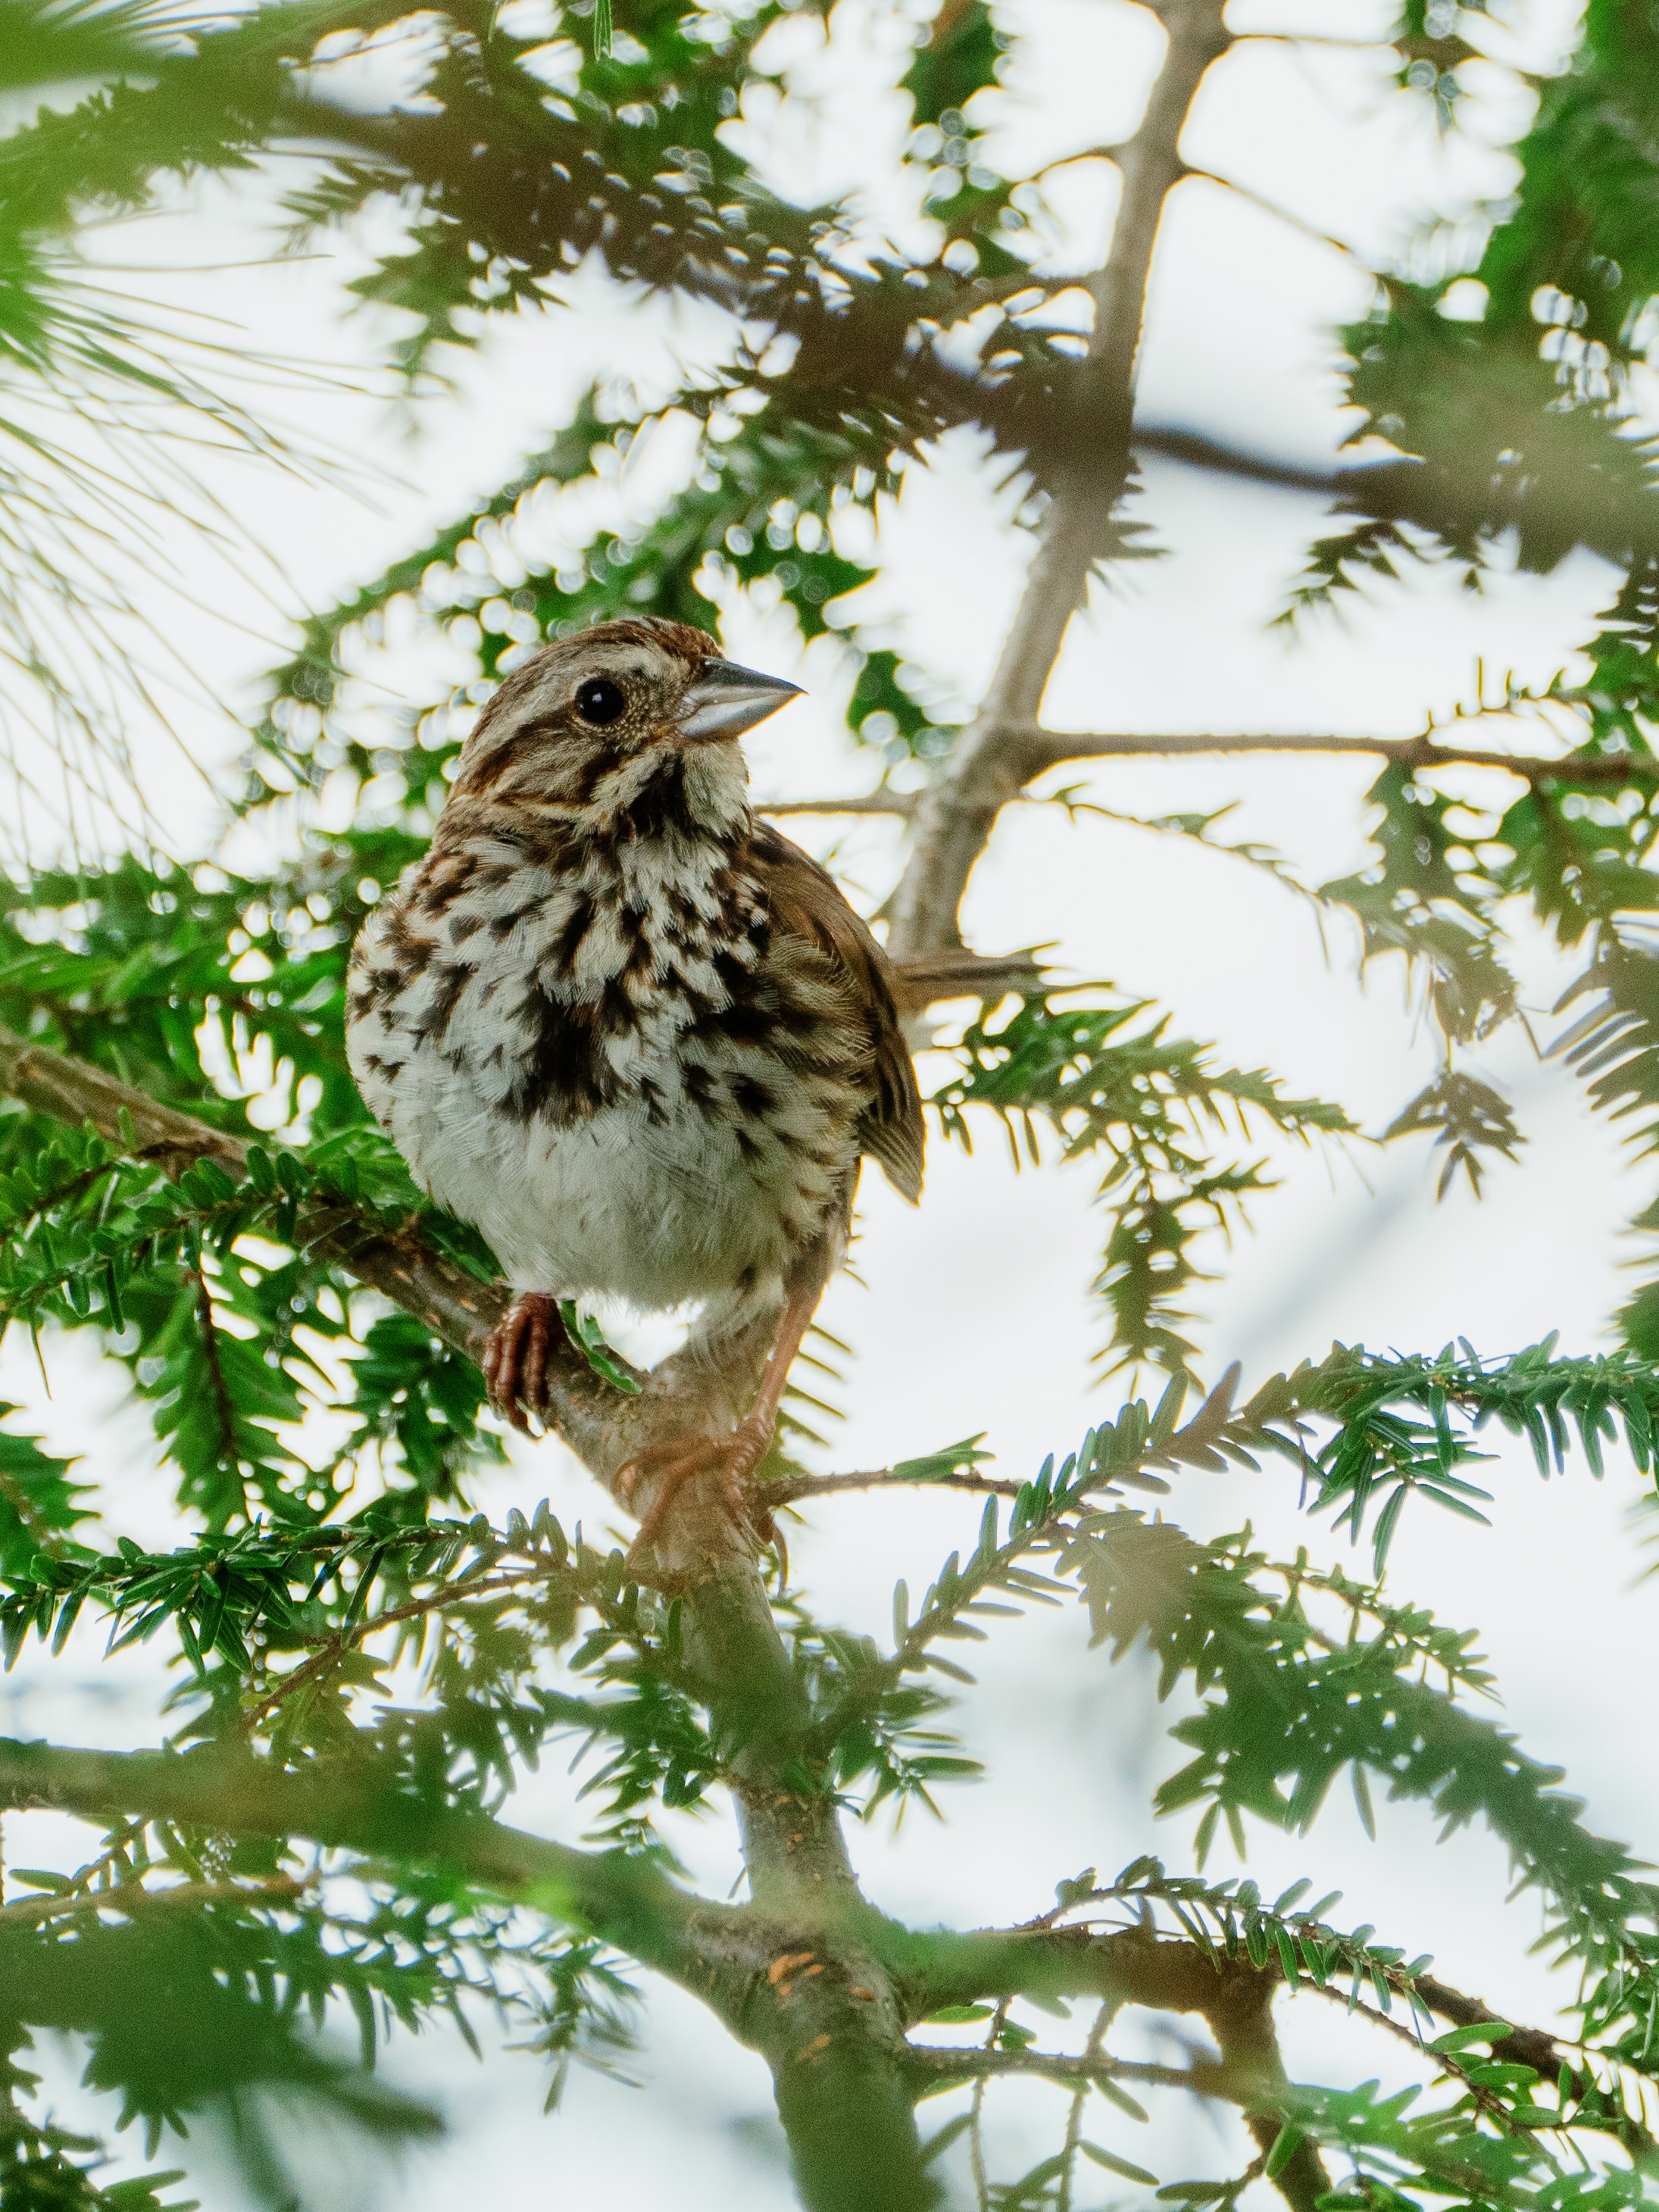</div> 
<center> Melospiza Melodia/Song Sparrow </center>
<center> Image Courtesy: <a href= "https://unsplash.com/@markolsen"> Mark Olsen </a> on Unsplash </center>

### When did a collision take place in Chicago before the 4th of July 2016?

The TIME_PREV function fetches the record that lies just before the specified timestamp, in this case, just before 2016-07-04. 

In [216]:
#Construct the TQL to be used
tql_query2 = "SELECT TIME_PREV(*, TIMESTAMP('2016-07-04T00:00:00Z')) "

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + 'tql'

#Construct the request body which has the SQL that is to be used to retrieve the data
request_body = '[{"name":"Chicago_Collisions", "stmt":"'+tql_query2+'","columns":[]}]' 

#Invoke the GridDB WebAPI
query_req4 = requests.post(url, data=request_body, headers=header_obj)

In [218]:
query_req4.text

'[{"columns":[{"name":"Date","type":"TIMESTAMP"},{"name":"Genus","type":"STRING"},{"name":"Species","type":"STRING"},{"name":"Locality","type":"STRING"}],"results":[["2016-05-30T04:37:39.000Z","Dumetella","carolinensis","MP"]],"offset":0,"limit":10000,"total":-1}]'

A bird of the genus 'Dumetella' and species 'Carolinensis' was killed in a collision as of 2016-05-30. This bird that died was a <b> Gray Catbird </b>.

<div>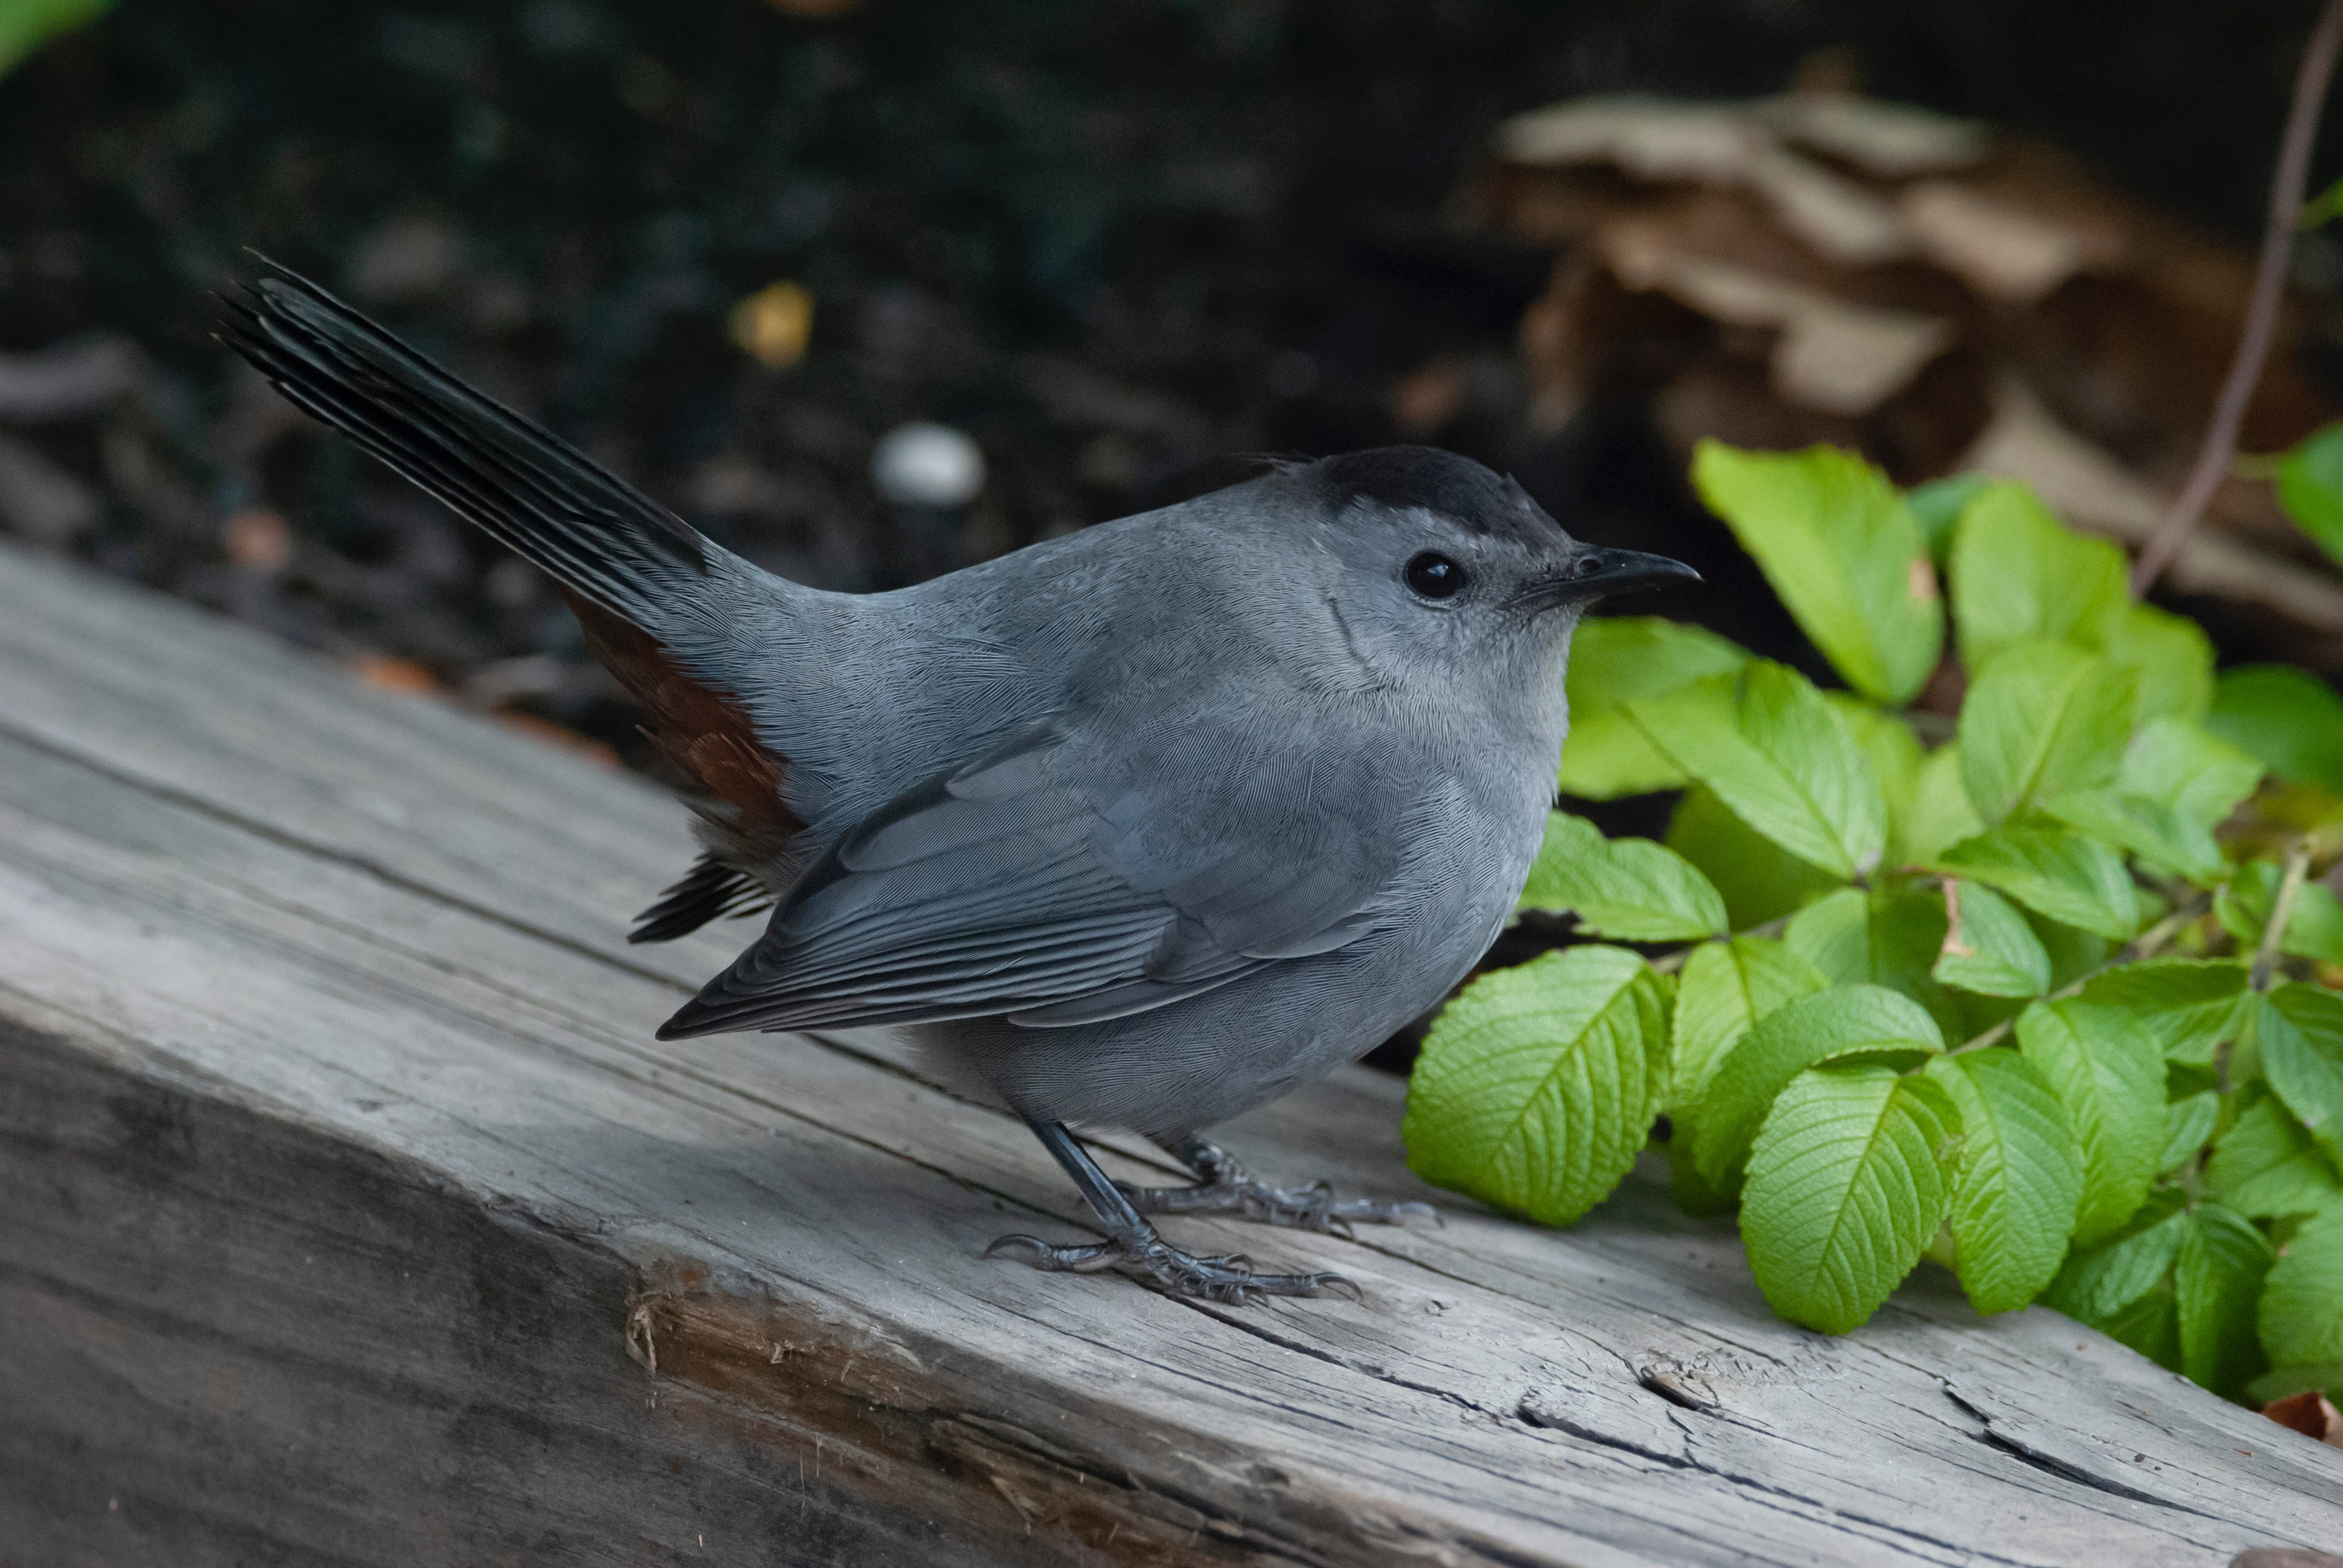</div> 
<center> Dumetella Carolinensis/Gray Catbird </center>
<center> Image Courtesy: <a href = "https://unsplash.com/@moultoty">Tyler Moulton</a> on Unsplash.

## In each year, how many birds of each species were killed?

In addition to TQL, GridDB also offers all standard SQL functions like Aggregation and Time functions. Read more about it <a href = "https://www.toshiba-sol.co.jp/en/pro/griddb/docs-en/v4_5/GridDB_SQL_Reference.html#extract"> GridDB's official SQL Reference. </a> 

In [219]:
#Construct the SQL to be used
sql_query1 = ("SELECT genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as cnt FROM Chicago_Collisions group by 1,2,3")

In [220]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query1+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as cnt FROM Chicago_Collisions group by 1,2,3"}]'

Invoke the GridDB SQL API to retrieve the results and process it. 

In [ ]:
#Invoke the GridDB WebAPI
data_req1 = requests.post(url, data=request_body, headers=header_obj)

In [222]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req1.json()
Chicago_Collision_Incidents = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"]])
Chicago_Collision_Incidents=Chicago_Collision_Incidents.sort_values(by=['cnt'], ascending=False)

In [223]:
print(Chicago_Collision_Incidents.to_markdown()) 

|      | Genus        | Species          |   Incident_Year |   cnt |
|-----:|:-------------|:-----------------|----------------:|------:|
|  773 | Zonotrichia  | albicollis       |            2013 |   984 |
|  655 | Zonotrichia  | albicollis       |            2010 |   859 |
| 2258 | Zonotrichia  | albicollis       |            2008 |   756 |
|    4 | Zonotrichia  | albicollis       |            2009 |   623 |
| 2285 | Zonotrichia  | albicollis       |            2006 |   567 |
| 2055 | Zonotrichia  | albicollis       |            2011 |   540 |
| 1293 | Zonotrichia  | albicollis       |            2007 |   520 |
| 1411 | Zonotrichia  | albicollis       |            2014 |   500 |
|  624 | Zonotrichia  | albicollis       |            2012 |   482 |
| 2410 | Melospiza    | melodia          |            1988 |   456 |
| 1630 | Zonotrichia  | albicollis       |            2015 |   453 |
|  479 | Zonotrichia  | albicollis       |            2005 |   432 |
|  705 | Melospiza    | melodia   

<b>Insights:</b> As you can see in the data table above, we see that birds of the <b> Zonotrichia albicollis </b> species (White-throated sparrow) are the ones that were most affected in any given year i.e., they had the <b> highest collisions in a specific year <b> since the data tracking was being done. This is followed by Seiurus aurocapilla (ovenbird). Atleast <b> 400-500 birds have been killed every year </b>.


<div>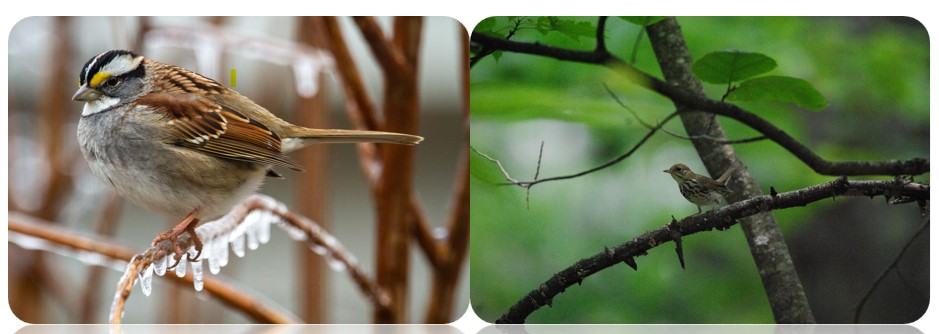</div> 
<center> Melospiza Lincolnii (Lincoln's Sparrows)</center>
<center> Image Courtesy: <a href= "https://unsplash.com/@jcotten"> Joshua J. Cotten </a> and <a href= "https://unsplash.com/@moultoty?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText"> Tyler Moulton
</a> on Unsplash </center>

In [224]:
Chicago_Collision_Incidents

Genus     Species  Incident_Year  cnt
773   Zonotrichia  albicollis           2013  984
655   Zonotrichia  albicollis           2010  859
2258  Zonotrichia  albicollis           2008  756
4     Zonotrichia  albicollis           2009  623
2285  Zonotrichia  albicollis           2006  567
...           ...         ...            ...  ...
1364   Ammodramus  savannarum           1981    1
1366   Ammodramus   leconteii           1987    1
1367      Piranga    olivacea           2005    1
1373     Spizella   passerina           1988    1
1212    Setophaga       fusca           1989    1

[2425 rows x 4 columns]

## Overall, how many birds were killed in each genus?

Let's add some subtotals to get insights for this.

In [231]:
def pivot_with_subtotals(df, values, indices, columns, aggfunc, fill_value):
    Table_list = []
    for i in range(len(indices)):
        n = i+1
        table = pd.pivot_table(df,values=values,index=indices[:n],columns=columns,aggfunc=aggfunc,fill_value=fill_value,sort=True).reset_index()
        for column in indices[n:]:
            table[column] = 'SubTotal'       
        Table_list.append(table)
    FinalTable = pd.concat(Table_list).sort_index()
    FinalTable = FinalTable.set_index(keys=indices)
    return FinalTable.sort_index(axis=0,ascending=False) # ascending=True/False controls the placement of the subtotals

In [237]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 5,
                       ):    
    display(pivot_with_subtotals(df=Chicago_Collision_Incidents,values='cnt',indices=['Genus','Species'],columns=[],aggfunc='sum',fill_value=''))


cnt
Genus        Species                
Zonotrichia  querula               2
             leucophrys         1090
             albicollis        10133
             SubTotal          11225
Vireo        solitarius           18
             philadelphicus       12
             olivaceus           133
             gilvus                2
             flavifrons           12
             SubTotal            177
Vermivora    cyanoptera           16
             chrysoptera          53
             SubTotal             69
Tyrannus     tyrannus              4
             SubTotal              4
Troglodytes  hiemalis            474
             aedon               104
             SubTotal            578
Toxostoma    rufum               166
             SubTotal            166
Sturnella    magna                13
             SubTotal             13
Spizelloides arborea            1262
             SubTotal           1262
Spizella     pusilla             325
             passerina            68
             pallida              50
             SubTotal            443
Sitta        canadensis          260
             SubTotal            260
Setophaga    virens              223
             tigrina             182
             striata             787
             ruticilla           868
             pinus                49
             petechia             77
             pensylvanica        303
             palmarum            694
             magnolia           1224
             fusca               201
             coronata            887
             citrina               5
             cerulea               3
             castanea            287
             caerulescens        183
             americana            59
             SubTotal           6032
Seiurus      aurocapilla        4580
             SubTotal           4580
Sayornis     phoebe               24
             SubTotal             24
Regulus      satrapa            1029
             calendula           416
             SubTotal           1445
Protonotaria citrea                6
             SubTotal              6
Pooecetes    gramineus            10
             SubTotal             10
Polioptila   caerulea              6
             SubTotal              6
Piranga      rubra                 9
             olivacea            127
             SubTotal            136
Pipilo       erythrophthalmus     82
             SubTotal             82
Pheucticus   ludovicianus        397
             SubTotal            397
Passerina    cyanea              725
             caerulea              1
             SubTotal            726
Passerella   iliaca             2443
             SubTotal           2443
Passerculus  sandwichensis       274
             SubTotal            274
Parkesia     noveboracensis      916
             motacilla            15
             SubTotal            931
Oreothlypis  ruficapilla        1690
             peregrina          2515
             celata              227
             SubTotal           4432
Oporornis    agilis              365
             SubTotal            365
Myiarchus    crinitus             28
             SubTotal             28
Mniotilta    varia               620
             SubTotal            620
Melospiza    melodia            5124
             lincolnii          2029
             georgiana          4910
             SubTotal          12063
Lanius       excubitor             1
             SubTotal              1
Junco        hyemalis           6303
             SubTotal           6303
Icterus      spurius               6
             galbula              83
             SubTotal             89
Icteria      virens               15
             SubTotal             15
Hylocichla   mustelina           500
             SubTotal            500
Geothlypis   trichas            1555
             philadelphia        430
             formosa              16
             SubTotal           2001
Empidonax    virescens             7


<b> Insights:</b> Birds of the species Melospiza have been killed the largest (12063 overall deaths). This is followed by Zonotrichia with an overall 11225 deaths across time. The third most affected are the Setophaga. These birds are different types of sparrows and warblers.

## How many birds were killed from 1978 to 2016 in Cleveland?

Let's move on to analyzing collisions in Cleveland.

In [251]:
#Construct the SQL to be used
sql_query2 = ("SELECT genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as cnt FROM Cleveland_Collisions group by 1,2,3")

In [252]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query2+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as cnt FROM Cleveland_Collisions group by 1,2,3"}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req2 = requests.post(url, data=request_body, headers=header_obj)

In [255]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req2.json()
Cleveland_Collision_Incidents = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"]])
Cleveland_Collision_Incidents=Cleveland_Collision_Incidents.sort_values(by=['cnt'], ascending=False)

In [256]:
def pivot_with_subtotals(df, values, indices, columns, aggfunc, fill_value):
    Table_list = []
    for i in range(len(indices)):
        n = i+1
        table = pd.pivot_table(df,values=values,index=indices[:n],columns=columns,aggfunc=aggfunc,fill_value=fill_value,sort=True).reset_index()
        for column in indices[n:]:
            table[column] = 'SubTotal'       
        Table_list.append(table)
    FinalTable = pd.concat(Table_list).sort_index()
    FinalTable = FinalTable.set_index(keys=indices)
    return FinalTable.sort_index(axis=0,ascending=False) # ascending=True/False controls the placement of the subtotals

In [257]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 5,
                       ):    
    display(pivot_with_subtotals(df=Cleveland_Collision_Incidents,values='cnt',indices=['Genus','Species'],columns=[],aggfunc='sum',fill_value=''))


cnt
Genus        Species              
Zonotrichia  leucophrys         13
             albicollis        579
             SubTotal          592
Vireo        philadelphicus      1
             olivaceus           3
             SubTotal            4
Troglodytes  hiemalis           34
             aedon              10
             SubTotal           44
Toxostoma    rufum               5
             SubTotal            5
Spizelloides arborea             2
             SubTotal            2
Spizella     pusilla             6
             SubTotal            6
Sphyrapicus  varius             21
             SubTotal           21
Sitta        canadensis          2
             SubTotal            2
Setophaga    virens             15
             tigrina             8
             striata            51
             ruticilla          16
             pinus               2
             petechia            6
             pensylvanica       10
             palmarum           15
             magnolia           54
             fusca              13
             coronata           24
             citrina             1
             castanea           61
             caerulescens       16
             americana          22
             SubTotal          314
Seiurus      aurocapilla       113
             SubTotal          113
Sayornis     phoebe              1
             SubTotal            1
Regulus      satrapa           166
             calendula          33
             SubTotal          199
Pipilo       erythrophthalmus    5
             SubTotal            5
Pheucticus   ludovicianus        8
             SubTotal            8
Passerina    cyanea              8
             SubTotal            8
Passerella   iliaca             10
             SubTotal           10
Passerculus  sandwichensis       2
             SubTotal            2
Parkesia     noveboracensis      6
             SubTotal            6
Oreothlypis  ruficapilla        70
             peregrina          44
             celata              8
             SubTotal          122
Oporornis    agilis              9
             SubTotal            9
Mniotilta    varia              27
             SubTotal           27
Melospiza    melodia            81
             lincolnii         114
             georgiana          76
             SubTotal          271
Megaceryle   alcyon              1
             SubTotal            1
Junco        hyemalis           43
             SubTotal           43
Icterus      galbula             1
             SubTotal            1
Icteria      virens              1
             SubTotal            1
Hylocichla   mustelina          16
             SubTotal           16
Geothlypis   trichas           167
             philadelphia       21
             formosa             2
             SubTotal          190
Empidonax    minimus             3
             SubTotal            3
Dumetella    carolinensis       31
             SubTotal           31
Contopus     virens              5
             SubTotal            5
Colaptes     auratus            18
             SubTotal           18
Coccyzus     americanus          4
             SubTotal            4
Cistothorus  palustris           4
             SubTotal            4
Certhia      americana          89
             SubTotal           89
Catharus     ustulatus          32
             minimus             9
             guttatus           29
             fuscescens          2
             SubTotal           72
Cardellina   pusilla            13
             canadensis          7
             SubTotal           20
Ammodramus   savannarum          4
             SubTotal            4

In Cleveland, <b> the genus Zonotrichia (592) followed by Setophaga (314) and Oreothlypis (122) </b> have been affected.

<div>
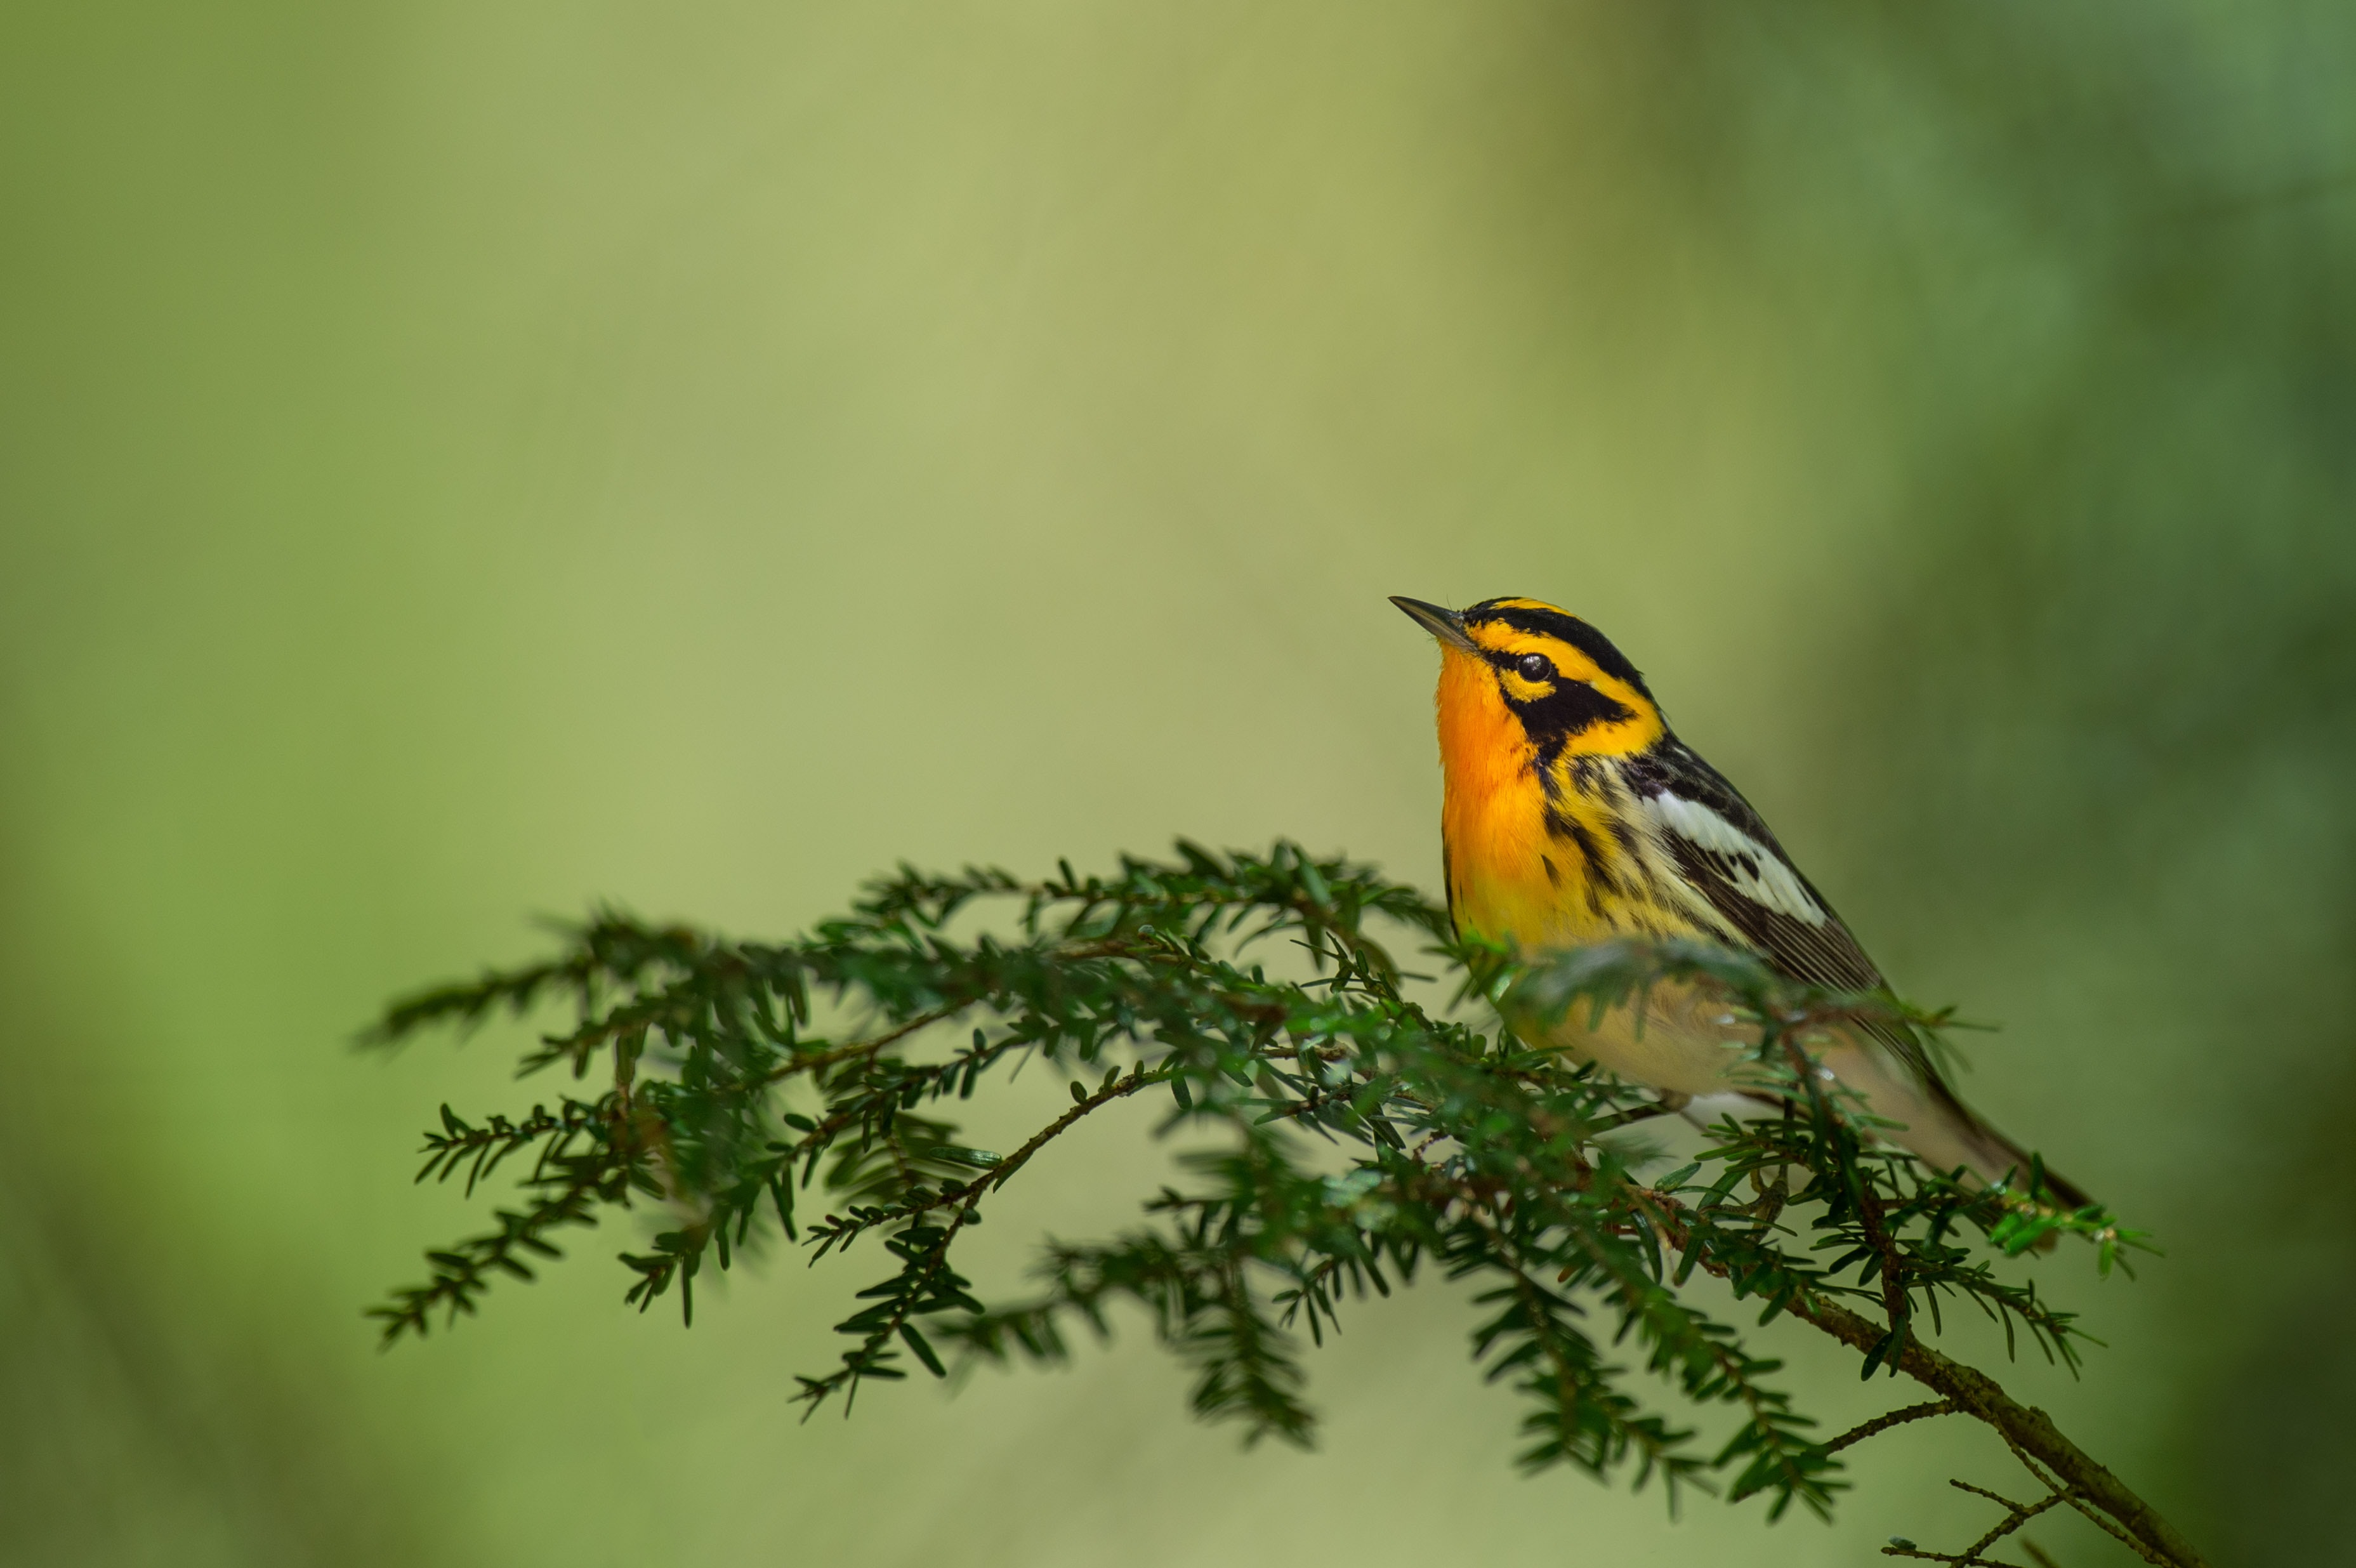
</div>
<center> Oreothlypis (Warbler) </center>
<center> Image Credit: <a href = "https://unsplash.com/@birdwatcher033342/collections"> Lydia Dexter </a> on Unsplash</center> 

# Exploring Joins and Subqueries in GridDB to answer deeper questions

In [258]:
sql_query3 = (f"""SELECT 'Chicago' as location, genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Chicago_Collisions group by 1,2,3,4 UNION ALL SELECT 'Cleveland' as location, genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Cleveland_Collisions group by 1,2,3,4 """)

In [259]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query3+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT \'Chicago\' as location, genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Chicago_Collisions group by 1,2,3,4 UNION ALL SELECT \'Cleveland\' as location, genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Cleveland_Collisions group by 1,2,3,4 "}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req3 = requests.post(url, data=request_body, headers=header_obj)

## What does the trend of Collisions look like? (Across Chicago and Cleveland)

In [262]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req3.json()
All_Collision_Incidents = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"],myJson[0]["columns"][4]["name"]])
All_Collision_Incidents=All_Collision_Incidents.sort_values(by=['Num'], ascending=False)

In [263]:
All_Collisions_grouped_by_Year = All_Collision_Incidents.groupby(['Incident_Year'])['Num'].sum().reset_index()

C:\Users\mg_su\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


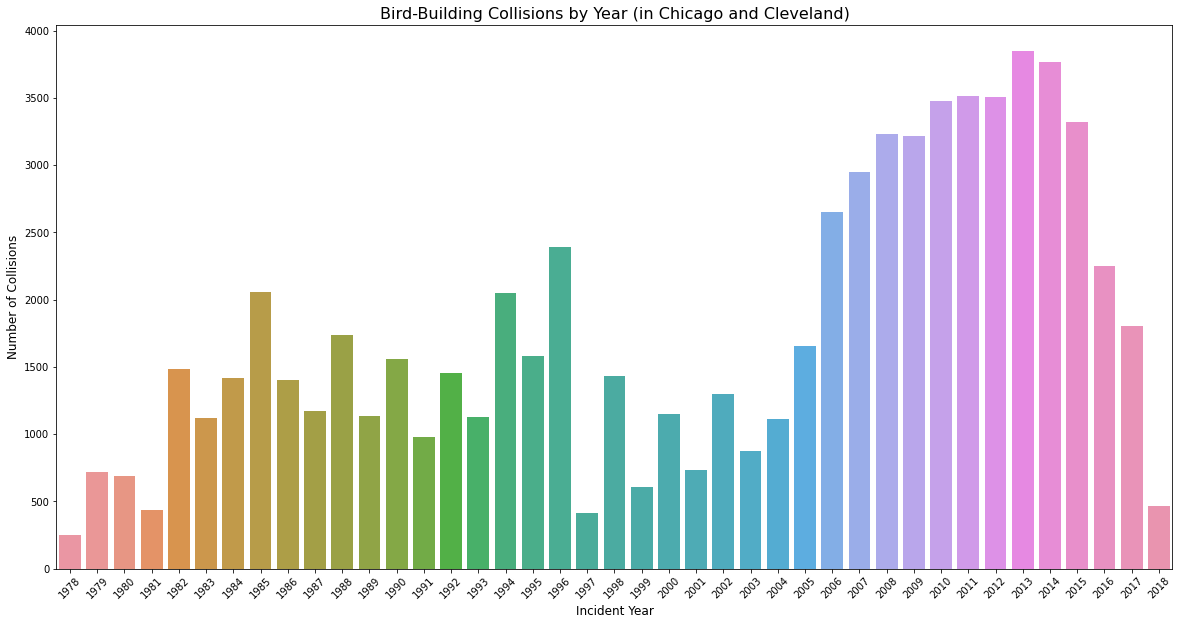

In [264]:
#Plot the data as a bar plot
fig,ax = plt.subplots(figsize=(20,10))
sns.barplot(All_Collisions_grouped_by_Year['Incident_Year'], All_Collisions_grouped_by_Year['Num'], ax=ax,order=All_Collisions_grouped_by_Year.Incident_Year)
ax.set_title('Bird-Building Collisions by Year (in Chicago and Cleveland)', fontsize = 16, loc='center')
ax.set_xlabel('Incident Year', fontsize = 12)
ax.set_ylabel('Number of Collisions', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

<b> Insight(s): </b> <li> There has been a dip in the collisions in the year 1997. Unfortunately, we do not have the data on the event that lead to the decrease in collisions.<li> Collisions have been the 2000s in years 1985 and 1996.<li> From 2006 onwards, they have skyrocketed to the 3000s and 4000s. 

## How many collisions take place on an average in Cleveland and Chicago?

In [265]:
sql_query4 = (f"""SELECT 'Chicago' as location, count(*)/count(distinct EXTRACT(YEAR, Date)) as Avg_Collisions FROM Chicago_Collisions group by 1 UNION ALL SELECT 'Cleveland' as location, count(*)/count(distinct EXTRACT(YEAR, Date)) as Avg_Collisions FROM Cleveland_Collisions group by 1""")

In [266]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query4+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT \'Chicago\' as location, count(*)/count(distinct EXTRACT(YEAR, Date)) as Avg_Collisions FROM Chicago_Collisions group by 1 UNION ALL SELECT \'Cleveland\' as location, count(*)/count(distinct EXTRACT(YEAR, Date)) as Avg_Collisions FROM Cleveland_Collisions group by 1"}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req4 = requests.post(url, data=request_body, headers=header_obj)

In [268]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req4.json()
Avg_Collisions = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"]])
Avg_Collisions=Avg_Collisions.sort_values(by=['Avg_Collisions'], ascending=False)

In [269]:
Avg_Collisions

location  Avg_Collisions
1    Chicago            1789
0  Cleveland            1136

<b>Insight(s):</b> In Chicago, there have been <b> around 1800 bird-building collisions per year on average </b> and in Cleveland, there have been <b> around 1140 collisions per year on an average</b>. Chicago seems to have more collisions than Cleveland. 

# How have collisions varied by year and locality in Chicago?
The Chicago collisions dataset has the 'Locality' wherein the collisions were recorded. The Two Localities recorded include Mc Cormick Place and the rest of Chicago. To refer to the dataset usage notes, check this <a href = " https://datadryad.org/stash/dataset/doi:10.5061/dryad.8rr0498">resource.</a>

In [270]:
sql_query5 = (f"""SELECT Locality, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Chicago_Collisions group by 1,2""")

In [271]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query5+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT Locality, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Chicago_Collisions group by 1,2"}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req5 = requests.post(url, data=request_body, headers=header_obj)

In [273]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req5.json()
Chicago_Collisions_by_Locality = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"]])
Chicago_Collisions_by_Locality=Chicago_Collisions_by_Locality.sort_values(by=['Num'], ascending=False)

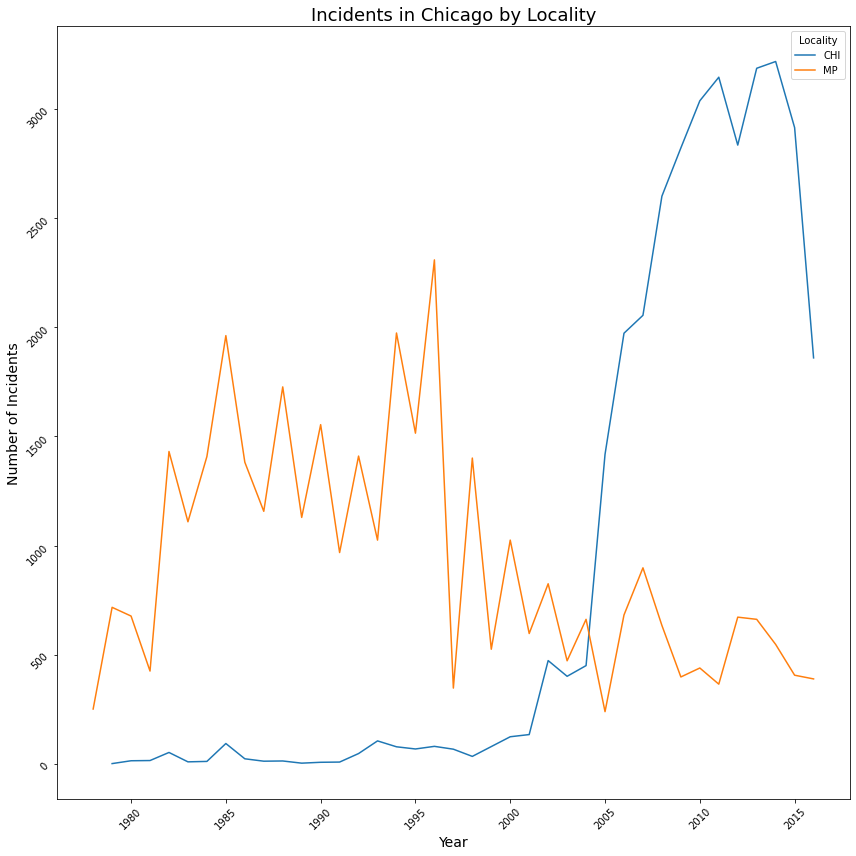

In [274]:
Chicago_Collisions_by_Locality
#Construct a line plot with the data
plt.rcParams["figure.figsize"] = [12,12]
plt.rcParams["figure.autolayout"] = True
ax = sns.lineplot(x="Incident_Year", y="Num", hue='Locality',data=Chicago_Collisions_by_Locality)
ax.tick_params(rotation=45)
ax.set_title('Incidents in Chicago by Locality',fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.show()

<b> Insight(s):</b> The trend lines indicate that bird-building collisions in McCormick Place (MP) were high compared to the rest of Chicago (CHI) from 1978 to 2004.
<b> However </b>, around 2004, there was a sudden dip in the collisions in McCormick place. The average numbers dropped from 2004 onwards. This seems to be related to the construction of the bird sanctuary in McCormick Place. Read more about it here in the <a href = 
"https://www.mccormickplace.com/about/history/"> official website of McCormick Place. </a> However, bird-building collisions in the rest of Chicago continue to increase at an alarmingly high rate.

## Are light levels and collisions strongly correlated? 

This particular question requires us running <b> a query that combines all three containers namely Chicago_Collisions, Cleveland_Collisions and Light_levels. </b> GridDB supports standard sub-query functionality along with joins. Before we start building the query, it is important to note that the Light Score is stored as an string (varchar). We will use type casting available in GridDB to cast the string as an integer. GridDB supports all standard type casting functions available with most popular databases. Refer to the 'Cast' section <a href = "https://www.toshiba-sol.co.jp/en/pro/griddb/docs-en/v4_3_2/GridDB_AE_SQL_Reference.html#cast"> here </a> to know more about the different <b> type cast operations </b> supported in GridDB.  

In [275]:
sql_query6 = (f"""SELECT t1.Incident_Date, t2.Light_Score, Sum(cnt) as Number_of_Collisions FROM (SELECT STRFTIME('%m-%Y', Date) as Incident_Date, count(*) as cnt FROM Chicago_Collisions group by 1 UNION ALL SELECT STRFTIME('%m-%Y', Date) as Incident_Date, count(*) as cnt FROM Cleveland_Collisions group by 1 ) t1 INNER JOIN (SELECT STRFTIME('%m-%Y', Date) AS Incident_Date, AVG(CAST(Light_Score AS INTEGER)) AS Light_Score FROM Light_levels group by 1) t2 ON t1.Incident_Date = t2.Incident_Date GROUP BY 1,2""")

In [276]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query6+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT t1.Incident_Date, t2.Light_Score, Sum(cnt) as Number_of_Collisions FROM (SELECT STRFTIME(\'%m-%Y\', Date) as Incident_Date, count(*) as cnt FROM Chicago_Collisions group by 1 UNION ALL SELECT STRFTIME(\'%m-%Y\', Date) as Incident_Date, count(*) as cnt FROM Cleveland_Collisions group by 1 ) t1 INNER JOIN (SELECT STRFTIME(\'%m-%Y\', Date) AS Incident_Date, AVG(CAST(Light_Score AS INTEGER)) AS Light_Score FROM Light_levels group by 1) t2 ON t1.Incident_Date = t2.Incident_Date GROUP BY 1,2"}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req6 = requests.post(url, data=request_body, headers=header_obj)

In [278]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req6.json()
Collisions_and_Light_Levels = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"]])
Collisions_and_Light_Levels=Collisions_and_Light_Levels.sort_values(by=['Number_of_Collisions'], ascending=False)

In [279]:
Collisions_and_Light_Levels.sort_values('Number_of_Collisions', ascending=False)

Incident_Date  Light_Score  Number_of_Collisions
31        10-2013    10.866667                  2096
108       09-2012    14.933333                  1479
91        09-2010    13.300000                  1298
53        10-2014    11.400000                  1275
88        09-2014    14.137931                  1255
..            ...          ...                   ...
106       08-2001    11.833333                    15
23        08-2004    11.083333                    13
29        08-2003     6.285714                    12
40        03-2001     9.444444                    10
34        08-2002    16.555556                     2

[123 rows x 3 columns]

C:\Users\mg_su\AppData\Local\Temp/ipykernel_19116/2485131425.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=Collisions_and_Light_Levels.corr()


<AxesSubplot:>

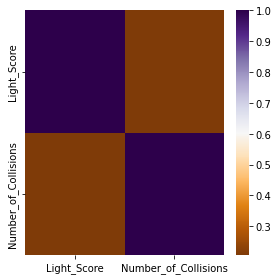

In [280]:

%matplotlib inline
plt.rcParams['figure.figsize']=4,4
    
# Calculate correlation between each pair of variable
corr_matrix=Collisions_and_Light_Levels.corr()
 
# plot it
sns.heatmap(corr_matrix, cmap='PuOr')  

<b> Insight(s): </b> Based on the limited data that we have, light_score and the number of collisions don't seem to have a strong correlation. However, we cannot say this with certainty as a lot of other studies show that there is a strong correlation between the light score and bird collisions. A lot more predictors like the weather, wind condition, etc. may be needed along with the light score.

Let's analyze the collisions and light levels are little more to see what we find.

## How many collisions occurred when the light score was the highest?

In [281]:
Collisions_and_Light_Levels.loc[(Collisions_and_Light_Levels['Light_Score']>=max(Collisions_and_Light_Levels['Light_Score']))]

Incident_Date  Light_Score  Number_of_Collisions
34       08-2002    16.555556                     2

<b> Insight: </b> There have been just 2 collisions when the light score has been the highest.

## How many collisions occurred when the light score was the lowest?

In [282]:
Collisions_and_Light_Levels.loc[(Collisions_and_Light_Levels['Light_Score']<=min(Collisions_and_Light_Levels['Light_Score']))]

Incident_Date  Light_Score  Number_of_Collisions
11       03-2002          3.3                    15

Insight: There have been 15 collisions when the light score was the lowest at 3.3.

# How many months had an average light score less than 10?

In [284]:
len(Collisions_and_Light_Levels.loc[(Collisions_and_Light_Levels['Light_Score']<=10)])

57

# Concluding Remarks

Bird-Building Collisions have led to an increased mass migration of birds. Based on several studies conducted over time, organizations like 'The Audubon Society' recommend turning the lights out after 11PM to save birds. Read more about it <a href = "https://blockclubchicago.org/2022/08/31/help-save-migrating-birds-by-turning-off-high-rise-lights-at-night-birders-say/" > here. </a> Using GridDB, we were able to effectively analyze time-series data and utilize both the TQL and SQL functionalities available in GridDB. Along with that, we also used the special time-series functions like TIME_NEXT AND TIME_PREVIOUS to get quick answers. Though the dataset is not as big, this is a good example to show how versatile GridDB can be for analyzing time-series data of any size.   